In [1]:
import logging
# set seed
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import utils as ut
import experiment as exp
from evaluation import *
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *
from plot import *
from tqdm.notebook import tqdm, trange
from sk_models import setup_pls_models_slim, StandardScaler, PLSRegression
seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)

In [2]:
#setup input and output formats, load data

file_name = "A_C_OF_SIWARE.csv"
id_cols =[]#["sample_id"]

data_path = Path('D:/workspace/lazydeep/data/soil_data/')
model_path = Path('D:/workspace/lazydeep/experiments/2.00/')
log_path = Path("D:/workspace/lazydeep/experiments/2.03")

data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
model_dir = model_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)

if not log_dir.exists():
    log_dir.mkdir()
print(log_dir)


D:\workspace\lazydeep\experiments\2.03\A_C_OF_SIWARE


In [3]:
data = pd.read_csv(data_file)
data = data.sample(frac=1)
nrow, ncol = data.shape
data = ut.sample_data(data,random_state)
n_features = ncol - 1-len(id_cols)

dataset = TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=None, ignore_cols= None)
print(data.shape)

(13916, 247)


In [4]:
n_models = 100
model_names = [f"random_{i}" for i in range(0,n_models)]
deep_models = {name:torch.load(model_dir/"models"/name/"_model") for name in model_names}
configs =  None
#for each model, load state
print(f"Loaded {len(deep_models)} models")
#print(deep_models)
for name in model_names:
    sub_path = log_dir / name
    if not sub_path.exists():
        sub_path.mkdir()

Loaded 100 models


In [5]:
# set logging, in this case the root logger
ut.setup_logger(logger_name="",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
summary_logger = logging.getLogger("summary")
tb = SummaryWriter(log_dir/"tb")


In [6]:
fixed_hyperparams = {'bs': 32,'loss': nn.MSELoss(),'epochs': 100}
preprocessing = StandardScaler()
eval = CrossValEvaluation(preprocessing=preprocessing,tensorboard=None,time=True,random_state=random_state)
scores={} #->model->knn:{fold_0:number,...,fold_n:number,mean:number,median:number
preds={} #model-> foldsxknn_models
deep_scores_dict={}
deep_preds_dict={}
actual_y = None

device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
load_fun_cv = lambda name,model, fold : model.load_state(model_dir/'models'/name/f"_fold_{fold}")
load_fun_pp_cv = lambda fold : preprocessing.from_state(preprocessing.load_state(model_dir/'preprocessing'/f"_fold_{fold}"))
load_fun_build = lambda name,model : model.load_state(model_dir/'models'/name/f"_final")
load_fun_pp_build = lambda : preprocessing.from_state(preprocessing.load_state(model_dir/'preprocessing'/f"_final"))


In [7]:
deep_scheme = DeepScheme(configs, fixed_hyperparams=fixed_hyperparams,loss_eval=loss_target,device=device,tensorboard=tb,adaptive_lr=False,update=False)
deep_scores, deep_preds, _ , _, _,_ = eval.evaluate(deep_models,dataset,deep_scheme,logger_name="log",load_fun=load_fun_cv,load_fun_pp=load_fun_pp_cv)
deep_scores_final, deep_preds_final, _ ,_, _,_ = eval.build(deep_models,dataset,deep_scheme,logger_name="test_log",load_fun=load_fun_build,load_fun_pp=load_fun_pp_build)

Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Tested (test) on 2320 instances with mean losses of: random_0:628.4683,random_1:258.9156,random_2:301.2125,random_3:682.699,random_4:153.2868,random_5:117.8278,random_6:404.3059,random_7:312.3909,random_8:343.6564,random_9:146.2347,random_10:156.4236,random_11:175.8986,random_12:180.1223,random_13:142.6379,random_14:307.0093,random_15:184.7355,random_16:116.8974,random_17:127.7617,random_18:145.4492,random_19:188.9521,random_20:424.769,random_21:343.6529,random_22:197.0028,random_23:133.7144,random_24:343.617,random_25:342.9373,random_26:126.9094,random_27:258.0966,random_28:197.9956,random_29:177.0037,random_30:215.7712,random_31:161.9369,random_32:216.8611,random_33:621.9322,random_34:132.3104,random_35:343.6219,random_36:119.5602,random_37:178.8677,random_38:148.7674,random_39:217.5964,random_40:111.1418,random_41:171.1611,random_42

In [8]:
all_scores = []
for k,v in ut.flip_dicts(deep_scores).items():
    dict1 = {'model_num':k,"predictor":"deep"}
    all_scores.append({**dict1,**v})

all_scores_final = []
for k,v in ut.flip_dicts(deep_scores_final).items():
    dict1 = {'model_num':k,"predictor":"deep"}
    all_scores_final.append({**dict1,**v})

In [9]:
scores_df_sorted = pd.DataFrame(all_scores).sort_values(by='MSE')
for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    print(s)

0 - random_77 - deep - 114.54153915931438 - 152.8207722639616 - 104.25755461725298 - 110.82466808728691 - 104.50628847004576 - 117.38991802182585 - 0.6620716666595301
1 - random_5 - deep - 117.82781637783708 - 160.39428847799428 - 106.77852464143754 - 108.9054703895467 - 112.2098785703066 - 121.22290283731783 - 0.6510377193474814
2 - random_94 - deep - 122.7633532030829 - 149.67107165337842 - 113.71855478257956 - 127.20804967711639 - 113.69057255687771 - 125.41009271592955 - 0.6389841280263233
3 - random_56 - deep - 114.26998714578563 - 166.4831926708542 - 116.44538460254874 - 109.14064373133151 - 128.5843738228558 - 126.9836186780309 - 0.6344544459650241
4 - random_40 - deep - 111.14184654498922 - 165.918114705351 - 138.65532447449758 - 111.19993794956511 - 115.57543765352224 - 128.4966362148703 - 0.6300989484644296
5 - random_66 - deep - 113.39283807688746 - 156.3097939501553 - 124.72496610101105 - 126.55761228053926 - 121.97465503950887 - 128.59066218726588 - 0.6298282775185955
6 - 

In [10]:
scores_df_sorted_final = pd.DataFrame(all_scores_final).sort_values(by='MSE')

for i,(index,row) in enumerate(scores_df_sorted_final.iterrows()):
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    print(s)

0 - random_26 - deep - 108.9328985074833 - 0.6688365711308477
1 - random_57 - deep - 110.37025384063605 - 0.664466913046357
2 - random_56 - deep - 115.68681646990136 - 0.6483042006405713
3 - random_16 - deep - 115.74186881727334 - 0.6481368377559626
4 - random_5 - deep - 116.05796744694129 - 0.6471758763981366
5 - random_77 - deep - 117.85318823448966 - 0.6417182829646813
6 - random_82 - deep - 118.04934539534422 - 0.6411219518390445
7 - random_18 - deep - 120.62528767974072 - 0.633290911894659
8 - random_55 - deep - 121.30038129414473 - 0.631238581338722
9 - random_36 - deep - 121.5920608791385 - 0.6303518555394353
10 - random_40 - deep - 122.32375614472875 - 0.6281274521097997
11 - random_79 - deep - 125.37283424443685 - 0.6188580470703312
12 - random_68 - deep - 126.28232979846372 - 0.6160931186571568
13 - random_89 - deep - 131.9252204730282 - 0.5989383467734897
14 - random_51 - deep - 134.01242141695366 - 0.592593113783276
15 - random_94 - deep - 134.0267225006046 - 0.592549637515

In [13]:
for deep_name,deep_model in tqdm(deep_models.items()):
    if int(deep_name.replace("random_","")) >52:
        logging.getLogger().info(f"Running model {deep_name}")
        temp_dict = {deep_name:deep_model}

        lwr_scheme = DeepLWRScheme_1_to_n(lwr_models = setup_pls_models_slim(nrow,kernal=True),n_neighbours=500,loss_fun_sk = mean_squared_error)
        lwr_scores, lwr_preds, _ , _, _,_= eval.evaluate(temp_dict,dataset,lwr_scheme,logger_name="log",load_fun=load_fun_cv,load_fun_pp = load_fun_pp_cv)
        lwr_scores_final, lwr_preds_final, _ , _, _,_= eval.build(temp_dict,dataset,lwr_scheme,logger_name="test_log",load_fun=load_fun_build,load_fun_pp = load_fun_pp_build)

        #scores
        for k,v in ut.flip_dicts(lwr_scores).items():
            dict1 = {'model_num':deep_name,"predictor":k}
            all_scores.append({**dict1,**v})

        for k,v in ut.flip_dicts(lwr_scores_final).items():
            dict1 = {'model_num':deep_name,"predictor":k}
            all_scores_final.append({**dict1,**v})

        lwr_preds['deep'] = deep_preds[deep_name]
        lwr_preds_final['deep'] = deep_preds_final[deep_name]

        lwr_preds.to_csv(log_dir/deep_name/ f"predictions.csv",index=False)
        lwr_preds_final.to_csv(log_dir/deep_name/ f"predictions_test.csv",index=False)

        #preds
        # todo save predictions - appending solns
        plot_preds_and_res(lwr_preds,name_lambda=lambda x:f"{deep_name} with {x} predictor",save_lambda= lambda x:f"deep_lwr{x}",save_loc=log_dir/deep_name)



  0%|          | 0/100 [00:00<?, ?it/s]

Running model random_53'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:96.0801,lwr_k=200:105.724,lwr_k=300:108.4904,lwr_k=400:110.532,lwr_k=500:111.9554,lwr_k=600:112.7711,lwr_k=700:113.852,lwr_k=800:114.4836,lwr_k=900:114.8868,lwr_k=1000:115.2364'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:126.2368,lwr_k=200:119.6827,lwr_k=300:118.3904,lwr_k=400:118.0156,lwr_k=500:117.5663,lwr_k=600:117.0436,lwr_k=700:116.6281,lwr_k=800:116.6192,lwr_k=900:116.3584,lwr_k=1000:116.2949'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:76.8718,lwr_k=200:86.3181,lwr_k=300:90.2931,lwr_k=400:91.7405,lwr_k=500:92.8531,lwr_k=600:94.013,lwr_k=700:94.8369,lwr_k=800:95.822,lwr_k=900:96.2484,lwr_k=1000:96.6989'
T

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_54'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:96.4056,lwr_k=200:105.3075,lwr_k=300:107.3223,lwr_k=400:108.0652,lwr_k=500:108.5532,lwr_k=600:109.5228,lwr_k=700:109.7035,lwr_k=800:109.9997,lwr_k=900:110.3453,lwr_k=1000:110.5467'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:122.5957,lwr_k=200:108.6575,lwr_k=300:104.9318,lwr_k=400:104.5299,lwr_k=500:102.2875,lwr_k=600:102.4947,lwr_k=700:102.0928,lwr_k=800:102.3772,lwr_k=900:102.063,lwr_k=1000:101.9989'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:70.4615,lwr_k=200:77.7537,lwr_k=300:81.0302,lwr_k=400:82.3359,lwr_k=500:83.4553,lwr_k=600:84.3331,lwr_k=700:84.9847,lwr_k=800:85.5723,lwr_k=900:85.9225,lwr_k=1000:86.323

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_55'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:90.4156,lwr_k=200:98.4593,lwr_k=300:101.343,lwr_k=400:103.7415,lwr_k=500:105.0623,lwr_k=600:106.8435,lwr_k=700:107.2966,lwr_k=800:107.8559,lwr_k=900:108.1422,lwr_k=1000:108.4133'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:108.6433,lwr_k=200:100.7086,lwr_k=300:99.6741,lwr_k=400:99.9709,lwr_k=500:100.9442,lwr_k=600:100.8503,lwr_k=700:100.3363,lwr_k=800:100.2462,lwr_k=900:100.5416,lwr_k=1000:100.6663'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:73.0989,lwr_k=200:78.7759,lwr_k=300:80.8179,lwr_k=400:83.3356,lwr_k=500:84.5684,lwr_k=600:85.5464,lwr_k=700:86.3689,lwr_k=800:86.8373,lwr_k=900:87.1358,lwr_k=1000:87.3777'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_56'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:106.8884,lwr_k=200:113.0944,lwr_k=300:114.5996,lwr_k=400:115.5047,lwr_k=500:116.5246,lwr_k=600:117.0764,lwr_k=700:117.6423,lwr_k=800:118.1261,lwr_k=900:118.4197,lwr_k=1000:118.6809'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:115.0646,lwr_k=200:109.9608,lwr_k=300:107.765,lwr_k=400:107.9585,lwr_k=500:107.3455,lwr_k=600:107.3065,lwr_k=700:107.6133,lwr_k=800:108.0488,lwr_k=900:108.4553,lwr_k=1000:108.7584'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:90.1468,lwr_k=200:96.8139,lwr_k=300:97.835,lwr_k=400:98.4843,lwr_k=500:99.3409,lwr_k=600:99.8747,lwr_k=700:100.5259,lwr_k=800:100.8341,lwr_k=900:101.0887,lwr_k=1000:101

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_57'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:102.4254,lwr_k=200:109.3717,lwr_k=300:112.3091,lwr_k=400:113.6685,lwr_k=500:114.497,lwr_k=600:115.1216,lwr_k=700:115.6114,lwr_k=800:116.012,lwr_k=900:116.3209,lwr_k=1000:116.5714'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:110.8415,lwr_k=200:110.374,lwr_k=300:111.3997,lwr_k=400:112.5367,lwr_k=500:112.4695,lwr_k=600:112.3376,lwr_k=700:112.8417,lwr_k=800:112.6524,lwr_k=900:112.7657,lwr_k=1000:112.7452'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:87.135,lwr_k=200:93.6083,lwr_k=300:95.7451,lwr_k=400:97.4486,lwr_k=500:98.3171,lwr_k=600:99.6012,lwr_k=700:100.3274,lwr_k=800:101.133,lwr_k=900:101.5855,lwr_k=1000:102.13

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_58'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:233.2317,lwr_k=200:263.8168,lwr_k=300:272.8079,lwr_k=400:277.5454,lwr_k=500:280.4077,lwr_k=600:281.4877,lwr_k=700:283.4241,lwr_k=800:282.9082,lwr_k=900:283.7425,lwr_k=1000:286.208'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:413.0233,lwr_k=200:347.5871,lwr_k=300:335.649,lwr_k=400:324.1983,lwr_k=500:308.5765,lwr_k=600:302.5075,lwr_k=700:302.5714,lwr_k=800:299.8842,lwr_k=900:312.8874,lwr_k=1000:302.7812'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:118.2024,lwr_k=200:141.5147,lwr_k=300:149.9897,lwr_k=400:154.6117,lwr_k=500:159.9717,lwr_k=600:163.0166,lwr_k=700:167.084,lwr_k=800:171.4013,lwr_k=900:173.749,lwr_k=1000

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_59'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:89.6787,lwr_k=200:101.7438,lwr_k=300:109.0837,lwr_k=400:113.3588,lwr_k=500:116.5431,lwr_k=600:119.4521,lwr_k=700:121.6711,lwr_k=800:123.1861,lwr_k=900:124.7577,lwr_k=1000:125.6627'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:149.7404,lwr_k=200:142.3925,lwr_k=300:136.7687,lwr_k=400:137.8344,lwr_k=500:140.7598,lwr_k=600:140.0146,lwr_k=700:141.1435,lwr_k=800:141.3622,lwr_k=900:142.2884,lwr_k=1000:143.0692'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:68.3416,lwr_k=200:83.2341,lwr_k=300:88.5287,lwr_k=400:91.7977,lwr_k=500:93.4369,lwr_k=600:94.7242,lwr_k=700:95.7165,lwr_k=800:96.8795,lwr_k=900:97.6028,lwr_k=1000:97.99

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_60'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:113.4938,lwr_k=200:118.2484,lwr_k=300:121.8421,lwr_k=400:123.6888,lwr_k=500:124.7616,lwr_k=600:125.9663,lwr_k=700:126.7686,lwr_k=800:127.5511,lwr_k=900:128.2459,lwr_k=1000:128.5825'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:131.6734,lwr_k=200:136.5611,lwr_k=300:139.9161,lwr_k=400:141.9403,lwr_k=500:143.2867,lwr_k=600:144.4759,lwr_k=700:145.2201,lwr_k=800:145.9426,lwr_k=900:146.273,lwr_k=1000:146.5661'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:216.0943,lwr_k=200:227.5832,lwr_k=300:232.9838,lwr_k=400:234.9487,lwr_k=500:238.6865,lwr_k=600:239.2351,lwr_k=700:243.9436,lwr_k=800:245.1211,lwr_k=900:247.1147,lwr_k=1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_61'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:101.6377,lwr_k=200:107.8312,lwr_k=300:110.7866,lwr_k=400:113.3601,lwr_k=500:114.948,lwr_k=600:116.0442,lwr_k=700:117.0191,lwr_k=800:118.4265,lwr_k=900:119.2822,lwr_k=1000:120.2906'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:114.2609,lwr_k=200:114.3085,lwr_k=300:113.0503,lwr_k=400:114.264,lwr_k=500:113.6394,lwr_k=600:114.4613,lwr_k=700:115.3394,lwr_k=800:115.7451,lwr_k=900:116.5406,lwr_k=1000:117.7189'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:86.8997,lwr_k=200:94.5248,lwr_k=300:97.8065,lwr_k=400:100.9547,lwr_k=500:102.2305,lwr_k=600:103.2458,lwr_k=700:104.5919,lwr_k=800:105.5878,lwr_k=900:106.4321,lwr_k=1000:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_62'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:101.5521,lwr_k=200:135.2484,lwr_k=300:143.3419,lwr_k=400:149.1799,lwr_k=500:152.7895,lwr_k=600:156.5778,lwr_k=700:160.5084,lwr_k=800:163.2612,lwr_k=900:166.8718,lwr_k=1000:171.3508'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:200.2129,lwr_k=200:160.0844,lwr_k=300:158.0733,lwr_k=400:155.5935,lwr_k=500:155.3043,lwr_k=600:162.0366,lwr_k=700:166.4733,lwr_k=800:166.745,lwr_k=900:167.7684,lwr_k=1000:171.8131'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:80.5022,lwr_k=200:110.4752,lwr_k=300:129.6802,lwr_k=400:139.8052,lwr_k=500:145.8918,lwr_k=600:151.547,lwr_k=700:156.8365,lwr_k=800:160.1877,lwr_k=900:162.623,lwr_k=1000

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_63'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:314.7109,lwr_k=200:309.7997,lwr_k=300:9967.9061,lwr_k=400:398.3837,lwr_k=500:309.5,lwr_k=600:351.3598,lwr_k=700:398.5045,lwr_k=800:309.6681,lwr_k=900:399.9606,lwr_k=1000:17948.4023'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:316.4043,lwr_k=200:313.719,lwr_k=300:9660.1153,lwr_k=400:411.3095,lwr_k=500:312.3982,lwr_k=600:353.4763,lwr_k=700:474.3531,lwr_k=800:312.9188,lwr_k=900:399.4993,lwr_k=1000:17760.9403'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:197.2532,lwr_k=200:214.554,lwr_k=300:221.0025,lwr_k=400:225.7083,lwr_k=500:227.911,lwr_k=600:234.4951,lwr_k=700:238.2414,lwr_k=800:240.3513,lwr_k=900:241.1918,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_64'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:212.0108,lwr_k=200:211.0843,lwr_k=300:210.5177,lwr_k=400:210.5533,lwr_k=500:210.5908,lwr_k=600:211.257,lwr_k=700:212.4278,lwr_k=800:213.1034,lwr_k=900:213.6428,lwr_k=1000:214.0325'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:219.1833,lwr_k=200:218.2488,lwr_k=300:217.2689,lwr_k=400:217.4299,lwr_k=500:217.5132,lwr_k=600:216.9392,lwr_k=700:218.0768,lwr_k=800:219.6145,lwr_k=900:220.4366,lwr_k=1000:220.6809'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:163.3169,lwr_k=200:164.2504,lwr_k=300:164.4798,lwr_k=400:166.418,lwr_k=500:167.675,lwr_k=600:169.4838,lwr_k=700:170.5389,lwr_k=800:171.3921,lwr_k=900:171.6739,lwr_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_65'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:72.0883,lwr_k=200:93.7042,lwr_k=300:100.4197,lwr_k=400:103.0155,lwr_k=500:105.7894,lwr_k=600:107.4028,lwr_k=700:108.5151,lwr_k=800:109.6331,lwr_k=900:110.3202,lwr_k=1000:110.5899'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:221.508,lwr_k=200:131.8588,lwr_k=300:116.7195,lwr_k=400:111.352,lwr_k=500:108.2139,lwr_k=600:105.905,lwr_k=700:102.7576,lwr_k=800:103.142,lwr_k=900:102.6478,lwr_k=1000:102.5831'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:61.917,lwr_k=200:79.6376,lwr_k=300:88.5678,lwr_k=400:93.349,lwr_k=500:93.515,lwr_k=600:96.4554,lwr_k=700:96.5303,lwr_k=800:96.7979,lwr_k=900:97.2312,lwr_k=1000:97.7092'
Test

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_66'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:103.2208,lwr_k=200:107.4417,lwr_k=300:109.0288,lwr_k=400:109.8835,lwr_k=500:110.4857,lwr_k=600:111.4531,lwr_k=700:111.7703,lwr_k=800:112.1042,lwr_k=900:112.3192,lwr_k=1000:112.5555'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:100.9087,lwr_k=200:100.3169,lwr_k=300:99.1474,lwr_k=400:99.1878,lwr_k=500:99.3164,lwr_k=600:99.4401,lwr_k=700:99.3391,lwr_k=800:99.4021,lwr_k=900:99.0717,lwr_k=1000:99.031'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:92.4166,lwr_k=200:96.5594,lwr_k=300:97.2703,lwr_k=400:97.5465,lwr_k=500:98.3449,lwr_k=600:98.6846,lwr_k=700:99.2341,lwr_k=800:99.5476,lwr_k=900:99.735,lwr_k=1000:99.8858'
Teste

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_67'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:355.0121,lwr_k=200:341.8789,lwr_k=300:340.4468,lwr_k=400:338.5653,lwr_k=500:337.9369,lwr_k=600:337.9893,lwr_k=700:337.883,lwr_k=800:337.872,lwr_k=900:338.0717,lwr_k=1000:338.3747'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:359.1625,lwr_k=200:346.8612,lwr_k=300:345.5834,lwr_k=400:344.0011,lwr_k=500:343.5918,lwr_k=600:343.6121,lwr_k=700:343.5869,lwr_k=800:343.6768,lwr_k=900:344.0134,lwr_k=1000:344.4167'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:342.141,lwr_k=200:325.3458,lwr_k=300:325.0387,lwr_k=400:323.1007,lwr_k=500:322.7478,lwr_k=600:322.7162,lwr_k=700:322.6374,lwr_k=800:322.6665,lwr_k=900:322.7149,lwr_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_68'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:152.5363,lwr_k=200:138.2167,lwr_k=300:127.199,lwr_k=400:124.6005,lwr_k=500:129.0947,lwr_k=600:130.7889,lwr_k=700:127.6906,lwr_k=800:130.7573,lwr_k=900:121.1819,lwr_k=1000:123.6915'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:286.2139,lwr_k=200:188.6393,lwr_k=300:197.413,lwr_k=400:155.6247,lwr_k=500:146.8293,lwr_k=600:135.8856,lwr_k=700:125.5678,lwr_k=800:126.3615,lwr_k=900:125.4049,lwr_k=1000:125.0669'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:103.7541,lwr_k=200:98.2248,lwr_k=300:99.7041,lwr_k=400:94.8293,lwr_k=500:96.4698,lwr_k=600:96.402,lwr_k=700:94.3693,lwr_k=800:97.3645,lwr_k=900:96.1294,lwr_k=1000:96.398

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_69'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:120.8347,lwr_k=200:120.184,lwr_k=300:120.7299,lwr_k=400:121.1559,lwr_k=500:121.2126,lwr_k=600:121.2218,lwr_k=700:121.2199,lwr_k=800:121.2154,lwr_k=900:121.2577,lwr_k=1000:121.2985'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:109.2149,lwr_k=200:110.5131,lwr_k=300:112.9548,lwr_k=400:113.9704,lwr_k=500:114.0672,lwr_k=600:114.0733,lwr_k=700:114.0155,lwr_k=800:113.9971,lwr_k=900:114.067,lwr_k=1000:114.0466'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:155.3042,lwr_k=200:155.8772,lwr_k=300:158.6989,lwr_k=400:161.1552,lwr_k=500:162.5002,lwr_k=600:163.876,lwr_k=700:164.8305,lwr_k=800:166.2031,lwr_k=900:167.416,lwr_k=1000

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_70'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:128.2618,lwr_k=200:130.2882,lwr_k=300:130.6155,lwr_k=400:130.1701,lwr_k=500:130.4134,lwr_k=600:130.6595,lwr_k=700:130.5822,lwr_k=800:130.8643,lwr_k=900:131.0005,lwr_k=1000:131.129'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:112.5776,lwr_k=200:113.3839,lwr_k=300:114.3143,lwr_k=400:115.4266,lwr_k=500:116.1172,lwr_k=600:116.528,lwr_k=700:116.8707,lwr_k=800:117.6632,lwr_k=900:118.1526,lwr_k=1000:118.8003'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:103.979,lwr_k=200:104.6373,lwr_k=300:104.897,lwr_k=400:105.0536,lwr_k=500:105.1048,lwr_k=600:105.1588,lwr_k=700:105.2419,lwr_k=800:105.1822,lwr_k=900:105.3085,lwr_k=1000

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_71'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:64.2256,lwr_k=200:99.8295,lwr_k=300:113.2822,lwr_k=400:121.8855,lwr_k=500:129.7608,lwr_k=600:135.948,lwr_k=700:141.2881,lwr_k=800:144.8293,lwr_k=900:147.0965,lwr_k=1000:150.4118'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:222.1908,lwr_k=200:172.4266,lwr_k=300:162.8366,lwr_k=400:157.7621,lwr_k=500:155.9321,lwr_k=600:154.7795,lwr_k=700:155.2865,lwr_k=800:157.5754,lwr_k=900:158.479,lwr_k=1000:160.5742'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:42.8742,lwr_k=200:66.3788,lwr_k=300:79.8755,lwr_k=400:89.2294,lwr_k=500:96.5895,lwr_k=600:101.5543,lwr_k=700:106.8081,lwr_k=800:109.5855,lwr_k=900:114.0295,lwr_k=1000:117.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_72'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:151.0417,lwr_k=200:155.1755,lwr_k=300:157.5092,lwr_k=400:159.0845,lwr_k=500:159.6876,lwr_k=600:160.745,lwr_k=700:161.4789,lwr_k=800:162.0019,lwr_k=900:162.2835,lwr_k=1000:162.7677'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:169.0286,lwr_k=200:168.2006,lwr_k=300:169.7362,lwr_k=400:171.5442,lwr_k=500:173.0096,lwr_k=600:173.7947,lwr_k=700:174.2973,lwr_k=800:175.4797,lwr_k=900:175.9239,lwr_k=1000:176.3579'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:270.6682,lwr_k=200:273.8727,lwr_k=300:274.9533,lwr_k=400:275.6968,lwr_k=500:276.6767,lwr_k=600:276.7416,lwr_k=700:277.1309,lwr_k=800:277.5761,lwr_k=900:277.7124,lwr_k=1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_73'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:83.2425,lwr_k=200:69.5517,lwr_k=300:88.8649,lwr_k=400:93.1616,lwr_k=500:102.2859,lwr_k=600:107.4175,lwr_k=700:107.8695,lwr_k=800:109.54,lwr_k=900:106.1289,lwr_k=1000:105.6991'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:157.1436,lwr_k=200:151.9315,lwr_k=300:179.4605,lwr_k=400:155.5758,lwr_k=500:227.0764,lwr_k=600:147.8114,lwr_k=700:167.3875,lwr_k=800:175.8755,lwr_k=900:166.2896,lwr_k=1000:145.5726'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:55.3976,lwr_k=200:78.6852,lwr_k=300:85.9361,lwr_k=400:90.3901,lwr_k=500:93.1482,lwr_k=600:95.781,lwr_k=700:97.5848,lwr_k=800:99.2774,lwr_k=900:101.3192,lwr_k=1000:102.7097'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_74'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:70.1036,lwr_k=200:91.9147,lwr_k=300:100.7468,lwr_k=400:105.6815,lwr_k=500:109.0257,lwr_k=600:111.8814,lwr_k=700:114.7646,lwr_k=800:116.6084,lwr_k=900:118.6453,lwr_k=1000:120.4099'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:131.8763,lwr_k=200:125.5141,lwr_k=300:123.2476,lwr_k=400:121.9497,lwr_k=500:122.6454,lwr_k=600:124.5343,lwr_k=700:125.7873,lwr_k=800:127.3314,lwr_k=900:128.8238,lwr_k=1000:129.9755'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:70.0247,lwr_k=200:84.7568,lwr_k=300:91.9432,lwr_k=400:96.4953,lwr_k=500:99.763,lwr_k=600:102.2833,lwr_k=700:103.2896,lwr_k=800:104.2484,lwr_k=900:104.9735,lwr_k=1000:105

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_75'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:109.8308,lwr_k=200:136.1615,lwr_k=300:142.9475,lwr_k=400:148.7142,lwr_k=500:153.7479,lwr_k=600:157.6872,lwr_k=700:160.9468,lwr_k=800:168.5356,lwr_k=900:170.2936,lwr_k=1000:173.5456'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:190.4971,lwr_k=200:189.0621,lwr_k=300:190.0505,lwr_k=400:175.4838,lwr_k=500:175.0814,lwr_k=600:176.8877,lwr_k=700:181.7975,lwr_k=800:183.3744,lwr_k=900:186.382,lwr_k=1000:188.5512'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:74.53,lwr_k=200:91.0217,lwr_k=300:96.2774,lwr_k=400:100.3228,lwr_k=500:103.0858,lwr_k=600:104.5299,lwr_k=700:105.5212,lwr_k=800:106.8587,lwr_k=900:108.4229,lwr_k=1000:1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_76'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:116.6188,lwr_k=200:121.3539,lwr_k=300:127.4332,lwr_k=400:131.0183,lwr_k=500:133.927,lwr_k=600:135.6702,lwr_k=700:137.0624,lwr_k=800:138.3499,lwr_k=900:139.5869,lwr_k=1000:140.7358'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:154.4529,lwr_k=200:145.3574,lwr_k=300:150.3172,lwr_k=400:150.7166,lwr_k=500:148.7499,lwr_k=600:147.3479,lwr_k=700:146.1243,lwr_k=800:146.3206,lwr_k=900:145.6374,lwr_k=1000:145.7179'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:81.1583,lwr_k=200:91.7588,lwr_k=300:96.3771,lwr_k=400:100.808,lwr_k=500:102.6178,lwr_k=600:104.5304,lwr_k=700:105.7049,lwr_k=800:106.4356,lwr_k=900:108.0785,lwr_k=1000:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_77'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:96.3745,lwr_k=200:101.4641,lwr_k=300:103.5577,lwr_k=400:104.1769,lwr_k=500:105.2189,lwr_k=600:105.7122,lwr_k=700:106.3953,lwr_k=800:106.8303,lwr_k=900:107.1714,lwr_k=1000:107.4951'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:104.5454,lwr_k=200:104.7042,lwr_k=300:106.099,lwr_k=400:105.0002,lwr_k=500:105.3527,lwr_k=600:106.8142,lwr_k=700:106.9428,lwr_k=800:107.2115,lwr_k=900:107.6215,lwr_k=1000:107.5265'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:70.7582,lwr_k=200:79.0918,lwr_k=300:81.7936,lwr_k=400:82.8419,lwr_k=500:83.8775,lwr_k=600:84.4934,lwr_k=700:85.1973,lwr_k=800:85.7681,lwr_k=900:86.2456,lwr_k=1000:86.343

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_78'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:101.7302,lwr_k=200:111.3357,lwr_k=300:112.5379,lwr_k=400:114.0907,lwr_k=500:114.9124,lwr_k=600:115.0851,lwr_k=700:115.5386,lwr_k=800:116.0491,lwr_k=900:116.2262,lwr_k=1000:116.6298'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:115.7145,lwr_k=200:107.3187,lwr_k=300:105.014,lwr_k=400:104.4413,lwr_k=500:105.3855,lwr_k=600:105.7121,lwr_k=700:106.1916,lwr_k=800:106.3301,lwr_k=900:106.4349,lwr_k=1000:106.2485'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:76.3131,lwr_k=200:81.2926,lwr_k=300:84.9782,lwr_k=400:86.9299,lwr_k=500:87.7009,lwr_k=600:88.1917,lwr_k=700:88.6006,lwr_k=800:89.1278,lwr_k=900:89.7131,lwr_k=1000:90.11

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_79'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:96.8931,lwr_k=200:106.1639,lwr_k=300:110.1024,lwr_k=400:112.6313,lwr_k=500:113.9907,lwr_k=600:115.0351,lwr_k=700:115.7144,lwr_k=800:116.3713,lwr_k=900:116.8944,lwr_k=1000:117.5193'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:134.8092,lwr_k=200:111.7924,lwr_k=300:113.2079,lwr_k=400:112.6287,lwr_k=500:113.4744,lwr_k=600:113.7497,lwr_k=700:113.2858,lwr_k=800:113.1486,lwr_k=900:112.2344,lwr_k=1000:112.3395'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:80.2772,lwr_k=200:88.3899,lwr_k=300:92.7875,lwr_k=400:95.4243,lwr_k=500:96.7789,lwr_k=600:97.6664,lwr_k=700:98.4214,lwr_k=800:98.9255,lwr_k=900:99.1226,lwr_k=1000:99.47

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_80'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:56.2304,lwr_k=200:85.5627,lwr_k=300:93.871,lwr_k=400:99.5793,lwr_k=500:102.8699,lwr_k=600:105.8474,lwr_k=700:108.3388,lwr_k=800:110.6468,lwr_k=900:112.0221,lwr_k=1000:113.6846'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:244.5422,lwr_k=200:119.3799,lwr_k=300:110.8381,lwr_k=400:106.7973,lwr_k=500:108.0338,lwr_k=600:107.9466,lwr_k=700:109.4531,lwr_k=800:107.9345,lwr_k=900:108.5745,lwr_k=1000:109.2641'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:49.8209,lwr_k=200:65.9056,lwr_k=300:76.1664,lwr_k=400:83.3094,lwr_k=500:87.125,lwr_k=600:91.8596,lwr_k=700:94.0264,lwr_k=800:97.5967,lwr_k=900:100.034,lwr_k=1000:102.0308'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_81'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:197.1391,lwr_k=200:195.3343,lwr_k=300:195.1529,lwr_k=400:195.6062,lwr_k=500:197.2399,lwr_k=600:198.7148,lwr_k=700:199.714,lwr_k=800:200.2658,lwr_k=900:201.4067,lwr_k=1000:201.9116'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:209.1931,lwr_k=200:205.3411,lwr_k=300:204.6127,lwr_k=400:204.6707,lwr_k=500:205.27,lwr_k=600:206.7856,lwr_k=700:207.6825,lwr_k=800:208.2805,lwr_k=900:209.2346,lwr_k=1000:209.5918'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:175.1194,lwr_k=200:175.5564,lwr_k=300:175.4993,lwr_k=400:177.764,lwr_k=500:179.365,lwr_k=600:180.6164,lwr_k=700:181.564,lwr_k=800:182.1564,lwr_k=900:181.7646,lwr_k=1000:1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_82'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:107.4215,lwr_k=200:101.8232,lwr_k=300:107.0891,lwr_k=400:105.0839,lwr_k=500:104.6237,lwr_k=600:105.5585,lwr_k=700:107.3421,lwr_k=800:107.3334,lwr_k=900:109.0578,lwr_k=1000:108.5837'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:185.9275,lwr_k=200:152.7147,lwr_k=300:126.2942,lwr_k=400:114.0552,lwr_k=500:107.7961,lwr_k=600:106.5293,lwr_k=700:102.0019,lwr_k=800:105.1149,lwr_k=900:100.8904,lwr_k=1000:100.0534'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:159.1741,lwr_k=200:172.1961,lwr_k=300:155.3435,lwr_k=400:147.053,lwr_k=500:140.1859,lwr_k=600:136.1157,lwr_k=700:141.1299,lwr_k=800:138.5212,lwr_k=900:134.3515,lwr_k=1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_83'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:67.7862,lwr_k=200:98.2024,lwr_k=300:110.8379,lwr_k=400:119.8741,lwr_k=500:124.7233,lwr_k=600:130.4704,lwr_k=700:134.7943,lwr_k=800:138.6003,lwr_k=900:142.2023,lwr_k=1000:144.006'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:232.6304,lwr_k=200:168.807,lwr_k=300:160.3394,lwr_k=400:160.5922,lwr_k=500:158.7455,lwr_k=600:158.8039,lwr_k=700:160.0675,lwr_k=800:160.863,lwr_k=900:161.0271,lwr_k=1000:162.1888'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:122.6245,lwr_k=200:116.8333,lwr_k=300:121.1923,lwr_k=400:125.1728,lwr_k=500:121.004,lwr_k=600:127.8215,lwr_k=700:135.6665,lwr_k=800:143.8057,lwr_k=900:150.6094,lwr_k=1000:1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_84'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:71.0535,lwr_k=200:88.5517,lwr_k=300:94.6404,lwr_k=400:97.4013,lwr_k=500:99.4483,lwr_k=600:100.6314,lwr_k=700:101.6316,lwr_k=800:102.5555,lwr_k=900:103.2682,lwr_k=1000:103.7883'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:173.4443,lwr_k=200:119.1653,lwr_k=300:109.4368,lwr_k=400:106.3132,lwr_k=500:106.0666,lwr_k=600:102.8783,lwr_k=700:101.4341,lwr_k=800:100.5738,lwr_k=900:99.7284,lwr_k=1000:98.772'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:40.0673,lwr_k=200:64.0707,lwr_k=300:69.5197,lwr_k=400:72.7675,lwr_k=500:74.6948,lwr_k=600:75.7247,lwr_k=700:76.7819,lwr_k=800:77.8488,lwr_k=900:78.299,lwr_k=1000:78.9274'
Test

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_85'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:101.9748,lwr_k=200:120.3576,lwr_k=300:128.5526,lwr_k=400:135.1506,lwr_k=500:139.2882,lwr_k=600:145.7626,lwr_k=700:152.6832,lwr_k=800:160.6514,lwr_k=900:166.3862,lwr_k=1000:170.9814'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:209.4696,lwr_k=200:155.4313,lwr_k=300:150.7715,lwr_k=400:149.9385,lwr_k=500:154.371,lwr_k=600:162.7473,lwr_k=700:166.9665,lwr_k=800:172.9638,lwr_k=900:176.6668,lwr_k=1000:178.9918'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:86.6845,lwr_k=200:109.774,lwr_k=300:123.0356,lwr_k=400:130.5224,lwr_k=500:137.9885,lwr_k=600:144.6234,lwr_k=700:149.7601,lwr_k=800:153.4551,lwr_k=900:158.0476,lwr_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_86'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:355.0121,lwr_k=200:341.8789,lwr_k=300:340.4468,lwr_k=400:338.5653,lwr_k=500:337.9369,lwr_k=600:337.9893,lwr_k=700:337.883,lwr_k=800:337.872,lwr_k=900:338.0717,lwr_k=1000:338.3747'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:359.1625,lwr_k=200:346.8612,lwr_k=300:345.5834,lwr_k=400:344.0011,lwr_k=500:343.5918,lwr_k=600:343.6121,lwr_k=700:343.5869,lwr_k=800:343.6768,lwr_k=900:344.0134,lwr_k=1000:344.4167'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:342.141,lwr_k=200:325.3458,lwr_k=300:325.0387,lwr_k=400:323.1007,lwr_k=500:322.7478,lwr_k=600:322.7162,lwr_k=700:322.6374,lwr_k=800:322.6665,lwr_k=900:322.7149,lwr_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_87'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:355.0121,lwr_k=200:600.6712,lwr_k=300:340.4468,lwr_k=400:616.8934,lwr_k=500:616.8934,lwr_k=600:616.8934,lwr_k=700:616.8934,lwr_k=800:337.872,lwr_k=900:618.517,lwr_k=1000:653.1694'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:359.1625,lwr_k=200:612.7451,lwr_k=300:345.5834,lwr_k=400:629.1592,lwr_k=500:629.1592,lwr_k=600:629.1592,lwr_k=700:629.1592,lwr_k=800:343.6768,lwr_k=900:630.8017,lwr_k=1000:665.845'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:144.2009,lwr_k=200:158.7724,lwr_k=300:171.4881,lwr_k=400:179.4411,lwr_k=500:183.941,lwr_k=600:187.3177,lwr_k=700:193.1333,lwr_k=800:197.6161,lwr_k=900:199.1185,lwr_k=1000

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_88'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:339.6882,lwr_k=200:341.2668,lwr_k=300:337.8672,lwr_k=400:337.8628,lwr_k=500:337.8682,lwr_k=600:337.9922,lwr_k=700:338.3777,lwr_k=800:338.1711,lwr_k=900:338.1347,lwr_k=1000:338.1206'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:345.9773,lwr_k=200:347.7481,lwr_k=300:343.6623,lwr_k=400:343.6451,lwr_k=500:343.6658,lwr_k=600:343.8963,lwr_k=700:344.4204,lwr_k=800:344.1508,lwr_k=900:344.1014,lwr_k=1000:344.0819'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:322.6336,lwr_k=200:322.714,lwr_k=300:322.6506,lwr_k=400:322.7837,lwr_k=500:322.7719,lwr_k=600:322.7702,lwr_k=700:322.6362,lwr_k=800:322.6552,lwr_k=900:322.6931,lwr_k=1

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_89'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:133.3112,lwr_k=200:138.1276,lwr_k=300:140.8289,lwr_k=400:141.8887,lwr_k=500:143.7393,lwr_k=600:145.4753,lwr_k=700:146.8886,lwr_k=800:147.9413,lwr_k=900:149.2765,lwr_k=1000:150.5433'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:157.06,lwr_k=200:158.6845,lwr_k=300:160.1123,lwr_k=400:159.4283,lwr_k=500:159.4477,lwr_k=600:159.4272,lwr_k=700:159.293,lwr_k=800:160.2458,lwr_k=900:160.7986,lwr_k=1000:161.541'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:199.4708,lwr_k=200:218.6493,lwr_k=300:235.2379,lwr_k=400:243.0646,lwr_k=500:255.9165,lwr_k=600:264.6701,lwr_k=700:268.0858,lwr_k=800:269.8465,lwr_k=900:270.7305,lwr_k=1000

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_90'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:105.0821,lwr_k=200:112.6736,lwr_k=300:115.2531,lwr_k=400:117.0886,lwr_k=500:118.0546,lwr_k=600:119.0011,lwr_k=700:119.789,lwr_k=800:120.3905,lwr_k=900:121.21,lwr_k=1000:121.9404'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:108.3667,lwr_k=200:106.9433,lwr_k=300:107.7008,lwr_k=400:107.6596,lwr_k=500:108.6834,lwr_k=600:110.6838,lwr_k=700:111.1674,lwr_k=800:112.6259,lwr_k=900:113.645,lwr_k=1000:114.9967'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:120.1074,lwr_k=200:120.7788,lwr_k=300:121.0159,lwr_k=400:120.7779,lwr_k=500:120.5119,lwr_k=600:120.6209,lwr_k=700:121.0196,lwr_k=800:121.0042,lwr_k=900:120.9623,lwr_k=1000

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_91'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:126.6219,lwr_k=200:160.7294,lwr_k=300:179.8453,lwr_k=400:191.3691,lwr_k=500:200.7009,lwr_k=600:208.1005,lwr_k=700:215.6579,lwr_k=800:220.6076,lwr_k=900:225.2023,lwr_k=1000:229.3483'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:195.7693,lwr_k=200:196.9553,lwr_k=300:219.6513,lwr_k=400:217.0888,lwr_k=500:215.0481,lwr_k=600:222.1329,lwr_k=700:227.8657,lwr_k=800:232.2258,lwr_k=900:238.1289,lwr_k=1000:244.5863'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:86.4358,lwr_k=200:104.161,lwr_k=300:114.1351,lwr_k=400:122.1915,lwr_k=500:128.8047,lwr_k=600:133.5012,lwr_k=700:138.6549,lwr_k=800:142.3867,lwr_k=900:145.0083,lwr_k=10

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_92'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:99.8468,lwr_k=200:103.2866,lwr_k=300:105.6691,lwr_k=400:108.9882,lwr_k=500:111.4219,lwr_k=600:112.3487,lwr_k=700:112.5405,lwr_k=800:112.9323,lwr_k=900:113.0248,lwr_k=1000:113.2296'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:151.0377,lwr_k=200:124.8054,lwr_k=300:113.1603,lwr_k=400:110.5578,lwr_k=500:112.6458,lwr_k=600:113.7923,lwr_k=700:113.9596,lwr_k=800:113.4929,lwr_k=900:113.4413,lwr_k=1000:112.9483'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:74.7263,lwr_k=200:82.7,lwr_k=300:86.9441,lwr_k=400:89.7363,lwr_k=500:90.5717,lwr_k=600:91.9688,lwr_k=700:92.3411,lwr_k=800:92.6914,lwr_k=900:93.089,lwr_k=1000:93.7155'


C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_93'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:57.8014,lwr_k=200:87.4475,lwr_k=300:99.367,lwr_k=400:104.3167,lwr_k=500:108.1225,lwr_k=600:110.9813,lwr_k=700:114.3897,lwr_k=800:117.447,lwr_k=900:118.5725,lwr_k=1000:121.0371'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:205.8599,lwr_k=200:158.3146,lwr_k=300:145.8779,lwr_k=400:140.4473,lwr_k=500:138.363,lwr_k=600:134.9263,lwr_k=700:132.3805,lwr_k=800:134.5644,lwr_k=900:134.5469,lwr_k=1000:133.7033'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:48.6237,lwr_k=200:69.0462,lwr_k=300:77.0349,lwr_k=400:86.431,lwr_k=500:91.5695,lwr_k=600:94.42,lwr_k=700:96.0226,lwr_k=800:97.433,lwr_k=900:98.543,lwr_k=1000:99.5641'
Tested

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_94'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:84.9681,lwr_k=200:101.1581,lwr_k=300:107.5379,lwr_k=400:110.464,lwr_k=500:112.2248,lwr_k=600:113.0901,lwr_k=700:113.5792,lwr_k=800:114.1574,lwr_k=900:114.2716,lwr_k=1000:114.6119'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:136.6034,lwr_k=200:113.7988,lwr_k=300:111.4309,lwr_k=400:109.8143,lwr_k=500:109.0122,lwr_k=600:109.0768,lwr_k=700:108.8637,lwr_k=800:108.7413,lwr_k=900:108.8323,lwr_k=1000:109.1819'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:60.4886,lwr_k=200:70.5213,lwr_k=300:74.8771,lwr_k=400:76.9063,lwr_k=500:78.0575,lwr_k=600:79.2162,lwr_k=700:80.0823,lwr_k=800:80.3914,lwr_k=900:80.9994,lwr_k=1000:81.366

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_95'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:334.2464,lwr_k=200:335.1749,lwr_k=300:338.2055,lwr_k=400:335.6396,lwr_k=500:334.8513,lwr_k=600:334.5777,lwr_k=700:334.3461,lwr_k=800:334.2237,lwr_k=900:334.2449,lwr_k=1000:334.311'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:339.7196,lwr_k=200:340.3653,lwr_k=300:343.0321,lwr_k=400:340.7658,lwr_k=500:340.1334,lwr_k=600:339.9295,lwr_k=700:339.7911,lwr_k=800:339.7816,lwr_k=900:339.8891,lwr_k=1000:340.0137'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:78.2022,lwr_k=200:89.6539,lwr_k=300:95.3834,lwr_k=400:99.4983,lwr_k=500:102.5259,lwr_k=600:105.3546,lwr_k=700:107.4409,lwr_k=800:109.9035,lwr_k=900:112.5962,lwr_k=1000:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_96'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:92.5392,lwr_k=200:103.6054,lwr_k=300:107.4509,lwr_k=400:110.807,lwr_k=500:111.9486,lwr_k=600:113.8598,lwr_k=700:115.6526,lwr_k=800:116.5981,lwr_k=900:116.9288,lwr_k=1000:117.3178'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:132.2076,lwr_k=200:119.6376,lwr_k=300:112.7962,lwr_k=400:110.5332,lwr_k=500:109.671,lwr_k=600:108.9107,lwr_k=700:109.2954,lwr_k=800:108.63,lwr_k=900:109.1292,lwr_k=1000:109.5476'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:69.602,lwr_k=200:83.1229,lwr_k=300:88.3848,lwr_k=400:90.873,lwr_k=500:92.1783,lwr_k=600:93.2626,lwr_k=700:94.1325,lwr_k=800:94.5883,lwr_k=900:94.6869,lwr_k=1000:94.8075'
Te

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_97'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:133.6503,lwr_k=200:141.3595,lwr_k=300:142.4186,lwr_k=400:142.8375,lwr_k=500:143.2176,lwr_k=600:143.5481,lwr_k=700:144.0637,lwr_k=800:144.5042,lwr_k=900:144.8413,lwr_k=1000:145.2085'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:117.3707,lwr_k=200:119.7665,lwr_k=300:119.9757,lwr_k=400:120.1897,lwr_k=500:119.7695,lwr_k=600:119.9452,lwr_k=700:120.1152,lwr_k=800:120.0974,lwr_k=900:119.7729,lwr_k=1000:119.8185'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:104.8483,lwr_k=200:105.79,lwr_k=300:106.5838,lwr_k=400:106.827,lwr_k=500:107.3731,lwr_k=600:107.2611,lwr_k=700:107.1623,lwr_k=800:107.3345,lwr_k=900:107.3024,lwr_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_98'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:95.7223,lwr_k=200:97.8237,lwr_k=300:89.6274,lwr_k=400:98.1225,lwr_k=500:89.5759,lwr_k=600:88.8116,lwr_k=700:88.4353,lwr_k=800:89.8305,lwr_k=900:87.7746,lwr_k=1000:89.8558'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:122.6229,lwr_k=200:117.2014,lwr_k=300:115.7358,lwr_k=400:133.0296,lwr_k=500:114.6915,lwr_k=600:116.1201,lwr_k=700:114.6111,lwr_k=800:114.7278,lwr_k=900:116.256,lwr_k=1000:115.2356'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:79.9349,lwr_k=200:88.168,lwr_k=300:90.9759,lwr_k=400:92.2593,lwr_k=500:93.2318,lwr_k=600:93.8423,lwr_k=700:94.086,lwr_k=800:94.5934,lwr_k=900:94.6526,lwr_k=1000:94.9102'
Tested (

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running model random_99'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 6956 - Val 2320 - Test 2320-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:108.0233,lwr_k=200:105.8745,lwr_k=300:106.7455,lwr_k=400:110.6646,lwr_k=500:111.4781,lwr_k=600:115.9404,lwr_k=700:117.4949,lwr_k=800:121.7921,lwr_k=900:122.0635,lwr_k=1000:123.8506'
Tested (test) on 2320 instances with mean losses of: lwr_k=100:176.876,lwr_k=200:119.8204,lwr_k=300:118.4451,lwr_k=400:125.6592,lwr_k=500:123.6949,lwr_k=600:126.2515,lwr_k=700:121.5555,lwr_k=800:123.6987,lwr_k=900:128.2002,lwr_k=1000:128.5077'
-----------------------------------Fold 1 - Train 6958 - Val 2319 - Test 2319-----------------------------------'
Finished training DeepLWR with a train loss of lwr_k=100:73.073,lwr_k=200:83.255,lwr_k=300:88.5249,lwr_k=400:95.7342,lwr_k=500:95.2215,lwr_k=600:98.7918,lwr_k=700:103.447,lwr_k=800:104.1757,lwr_k=900:106.1153,lwr_k=1000:108.5

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [14]:
scores_df = pd.DataFrame(all_scores)
scores_df.to_csv(log_dir/f"scores.csv",index=False)
scores_df_final = pd.DataFrame(all_scores_final)
scores_df_final.to_csv(log_dir/f"test_scores.csv",index=False)

scores_df_sorted = pd.DataFrame(scores_df).sort_values(by='MSE')

best_5 = []
summary_logger.info(f"Rank - " +" - ".join(list(scores_df_sorted.columns)))
for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    if i < 5:
        best_5.append((row["model_num"],row["predictor"],row["MSE"]))
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    summary_logger.info(s)

Rank - model_num - predictor - fold_0 - fold_1 - fold_2 - fold_3 - fold_4 - MSE - R2'
0 - random_94 - lwr_k=400 - 109.81433120454068 - 140.0376676193041 - 105.29718226093107 - 110.50896443432111 - 86.08183586954807 - 110.34795025624979 - 0.6823432582161852'
1 - random_94 - lwr_k=600 - 109.07680966388425 - 139.74040490726495 - 104.07103887906435 - 111.3578717091122 - 87.75857820316799 - 110.40082648389846 - 0.6821910443313447'
2 - random_94 - lwr_k=500 - 109.01216314204663 - 139.59613592555834 - 104.9651126822996 - 111.079910669079 - 88.15670311957922 - 110.56187145455927 - 0.6817274469510402'
3 - random_94 - lwr_k=900 - 108.83228657833533 - 141.90303360535188 - 103.42769107610914 - 111.26725778226336 - 88.7230827537473 - 110.83049802527205 - 0.6809541562735872'
4 - random_94 - lwr_k=700 - 108.8637499542879 - 140.84025263886275 - 102.88927351347792 - 113.01019166824204 - 88.59206424973057 - 110.8389360568303 - 0.680929865857629'
5 - random_94 - lwr_k=1000 - 109.18190322277718 - 141.6964

In [15]:
summary_logger.info("-----------------------\n Best 5 on Test Sest \n ---------------------")
summary_logger.info(f"Rank -  Deep Model - Predictor - Val Set - Test Set")
for i, (j,k,v) in enumerate(best_5):

    row = scores_df_final.loc[(scores_df_final['model_num']==j) & (scores_df_final['predictor'] == k)].iloc[0]
    #print(row)
    s = f"{i} - {j} - {k} - {v} - {row['MSE']} - {row['R2']}"
    summary_logger.info(s)


-----------------------
 Best 5 on Test Sest 
 ---------------------'
Rank -  Deep Model - Predictor - Val Set - Test Set'
0 - random_94 - lwr_k=400 - 110.34795025624979 - 106.66128087954492 - 0.6757424396374805'
1 - random_94 - lwr_k=600 - 110.40082648389846 - 118.22458069814591 - 0.6405892204186497'
2 - random_94 - lwr_k=500 - 110.56187145455927 - 111.47235834632875 - 0.6611164363752827'
3 - random_94 - lwr_k=900 - 110.83049802527205 - 123.7999458439546 - 0.6236397305437644'
4 - random_94 - lwr_k=700 - 110.8389360568303 - 118.86573100334067 - 0.6386400798113574'


Wrote Summary Graph'


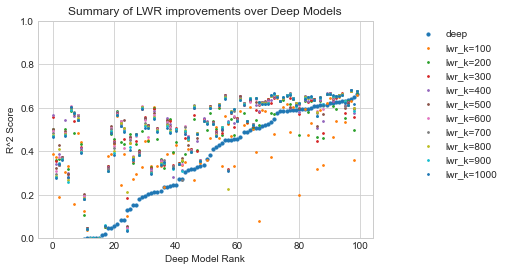

In [16]:
#take 1 is a scatter plot - lets, for each dataset
#graph our deep models by rank - plot - then overlay our knn moels
#plot points

deep_set = scores_df[scores_df["predictor"]=="deep"].sort_values("R2")
deep_set["order"] = [i for i in range(0,100)]
deep_ordering = {row["model_num"]:row["order"] for index, row in deep_set.iterrows()}

def order_models(x):
    x = [deep_ordering[i] for i in x]
    return x

fig, ax = plt.subplots()
set_deep = False
knn_models = scores_df["predictor"].unique()
for knn_model in knn_models:
    subset = scores_df[scores_df["predictor"]==knn_model]
    s=3
    if knn_model == "deep":
        s=10
    ax.scatter(x=order_models(subset["model_num"].tolist()), y=subset["R2"], s=s, label=knn_model)

#ax.set_ylim(0,scores_db["deep_mean"].max())
ax.set_ylim(0,1)
# plot residuals
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylabel("R^2 Score")
ax.set_xlabel("Deep Model Rank")
#ax.set_ylim(0,200)
#ax.set_yscale("symlog")
ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(log_dir/f"summary_plot.png", bbox_inches='tight')
logging.getLogger().info("Wrote Summary Graph")

In [17]:
scores_df["n_features"] = [deep_models[i].n_features for i in scores_df["model_num"]] 
from matplotlib.colors import Colormap
import seaborn as sns #heatmap of features - pls model - score
class nlcmap(Colormap):
    def __init__(self, cmap, levels):
        self.cmap = cmap
        self.N = cmap.N
        self.monochrome = self.cmap.monochrome
        self.levels = np.asarray(levels, dtype='float64')
        self._x = self.levels
        self.levmax = self.levels.max()
        self.levmin = self.levels.min()
        self.transformed_levels = np.linspace(self.levmin, self.levmax, #uniform spacing along levels (colour segments)
             len(self.levels))

    def __call__(self, xi, alpha=1.0, **kw):
        yi = np.interp(xi, self._x, self.transformed_levels)
        return self.cmap((yi-self.levmin) / (self.levmax-self.levmin), alpha)
    
levels = np.concatenate((
    [0, 1],
    [0.6,0.8,0.9,0.95,0.98]
    ))

levels = levels[levels <= 1]
levels.sort()
cmap_nonlin = nlcmap(plt.cm.YlGnBu, levels)


In [18]:
subset = scores_df[["predictor","n_features","R2"]]
subset = subset[np.logical_not(subset["predictor"]=="deep")]
subset = subset[np.logical_not(subset["predictor"]=="lr")]
trans = subset["predictor"].transform(lambda x: int(x.replace("lwr_k=",""))).tolist()
subset.loc[:,"predictor"]=trans
subset=subset.sort_values("predictor",ascending=False)

def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

C:\Users\huonf\AppData\Local\Temp\ipykernel_73772\3702862414.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = fig.colorbar(sc,label="R2 Score")


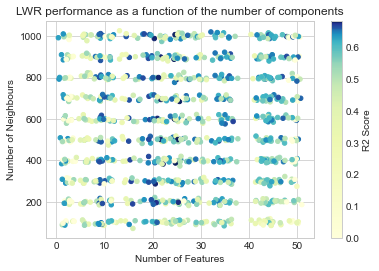

In [19]:
fig, ax = plt.subplots()
sc = ax.scatter(x=rand_jitter(subset["n_features"]), y=rand_jitter(subset["predictor"]), s=20,c=subset["R2"],cmap=cmap_nonlin,vmin=0)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Number of Neighbours")

cbar = fig.colorbar(sc,label="R2 Score")

ax.set_title("LWR performance as a function of the number of components")
plt.savefig(log_dir/f"heat_scatter.png", bbox_inches='tight')